# Project 1

#### Data Collection and Cleaning

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

df = pd.read_csv("hf://datasets/ailsntua/Chordonomicon/chordonomicon_v2.csv")

C:\Users\eca4zm\AppData\Local\Temp\ipykernel_23932\2445368653.py:7: DtypeWarning: Columns (2,3,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("hf://datasets/ailsntua/Chordonomicon/chordonomicon_v2.csv")


In [ ]:
rock = df.query("rock_genre == 'classic rock'")
rock

,id,chords,release_date,genres,decade,rock_genre,artist_id,main_genre,spotify_song_id,spotify_artist_id
465,466,<verse_1> G C G C <chorus_1> C/D G Dmin C C/D ...,1963,'british blues' 'british invasion' 'classic ro...,1960.0,classic rock,artist_293,jazz,3f6KsfF6num3gcWlVAUDY2,5670CyWrIOA7702gNjsGMZ
478,479,<verse_1> Gmin D F C Cmin Bb A7 D7 <verse_2> G...,1994-01-01,'british blues' 'british invasion' 'classic ro...,1990.0,classic rock,artist_293,jazz,779vozNXnMDlOVIkga6rIe,5670CyWrIOA7702gNjsGMZ
9067,9068,<intro_1> G E7 Amin D7 G E7 Amin D7 <verse_1> ...,2012-01-01,'classic rock' 'mellow gold' 'rock',2010.0,classic rock,artist_5310,rock,5XcVPg8yyACsI28cS9sbxp,4STHEaNw4mPZ2tzheohgXB
10335,10336,<intro_1> G G/A G/B G/C D G G/A G/B G/C D G G/...,NaN,'classic rock' 'mellow gold' 'rock',NaN,classic rock,artist_5310,rock,NaN,4STHEaNw4mPZ2tzheohgXB
10922,10923,<intro_1> E A E <verse_1> B E B A B <chorus_1>...,2010-10-05,'classic rock' 'rock',2000.0,classic rock,artist_6138,rock,2ijHRr643f31GnagPYgcdE,4x1nvY2FN8jxqAFA0DA02H
...,...,...,...,...,...,...,...,...,...,...
634007,634008,<intro_1> G A E <verse_1> B G A E C G A <choru...,2021-04-16,'classic rock' 'mellow gold' 'rock',2020.0,classic rock,artist_5310,rock,4ByvgSH9KPxMQqqXFR9797,4STHEaNw4mPZ2tzheohgXB
634089,634090,<intro_1> A D A <verse_1> G Fs F E Ds D E A D ...,2020-12-18,'classic rock' 'mellow gold' 'rock',2010.0,classic rock,artist_5310,rock,6hOvsDkEEo0hvYDPt7Tpu8,4STHEaNw4mPZ2tzheohgXB
634096,634097,<instrumental_1> Fsmin Dmin Fsmin Dmin Fsmin D...,2020-12-18,'classic rock' 'mellow gold' 'rock',2010.0,classic rock,artist_5310,rock,3z5OdBycnAWmwACAhF1phF,4STHEaNw4mPZ2tzheohgXB
634097,634098,<intro_1> Amin <verse_1> D F A D F Amin <choru...,2020-12-18,'classic rock' 'mellow gold' 'rock',2010.0,classic rock,artist_5310,rock,18kdKpv7ZuLGoAy9tmcWi9,4STHEaNw4mPZ2tzheohgXB


In [ ]:
def get_songs(data):
  songs = data["chords"]

  #remove any <verse>/<chorus> tags from the chord data
  cleaned_songs = [re.sub(r'<[^>]+>', '', song).strip() for song in songs]
  #collapse multiple spaces into one
  cleaned_songs = [' '.join(song.split()) for song in cleaned_songs]

  #convert from string of chords to list where each index is chord
  songs = [song.split() for song in cleaned_songs]

  return songs


#### State Space

In [ ]:
def get_states(songs, order=1):
  if order != 1:
    higher_order_songs = []
    for song in songs:
      higher_song = ['_'.join(song[(t-order-1):(t-1)]) for t in range(order+1, len(song))]
      higher_order_songs.append(higher_song)
    higher_order_states = set()
    for song in higher_order_songs:
      new_states = set(song)
      higher_order_states = higher_order_states.union(new_states)

    higher_order_states = list(higher_order_states)
    return higher_order_states, higher_order_songs
  
  else:
    states = set()
    for song in songs:
      new_states = set(song)
      states = states.union(new_states)

    states = list(states)
    return states

#### Tranistion matrix and Heat Map

In [ ]:
def transition_matrix_and_heat_map(states, songs):
    S = len(states)

    # Initialize transition count matrix
    tr_counts = np.zeros((S, S))

    # Count transitions across all trajectories
    for song in songs:
        for t in range(1, len(song)):
            prev_state = song[t-1]
            curr_state = song[t]
            i = states.index(prev_state)
            j = states.index(curr_state)
            tr_counts[j, i] += 1

    # Compute total outgoing transitions per state
    sums = tr_counts.sum(axis=0, keepdims=True)

    # Normalize to get transition probabilities (columns sum to 1)
    tr_pr = np.divide(
        tr_counts, 
        sums, 
        out=np.zeros_like(tr_counts), 
        where=sums != 0
    )

    # Convert to DataFrame for readability
    TM = pd.DataFrame(np.round(tr_pr, 3), index=states, columns=states)

    plt.figure(figsize=(13, 11))
    sns.heatmap(tr_pr, 
                cmap='Blues',
                square=True,          
                xticklabels=states,
                yticklabels=states,
                cbar_kws={'label': 'Transition Probability'})

    plt.title('Transition Probabilities')
    plt.xlabel('...From State')
    plt.ylabel('To State...')
    plt.show()

    return (TM, tr_pr)

#### Clean Chords for Music 21

In [ ]:
from music21 import harmony

MANUAL_MAPPINGS = {
    'Cminmaj7': 'CmM7',
    'Fsminmaj7': 'F#mM7',
}

def normalize_chord_string(chord_str: str) -> str:
    """
    Cleans up chord names to match what music21 expects.  
    Args:
        chord_str: A string containing a chord name
    Returns:
        A string containing a normalized chord name
    """
    original_str = chord_str.strip()
    
    #Check if this chord has a manual change
    if original_str in MANUAL_MAPPINGS:
        return MANUAL_MAPPINGS[original_str]
    normalized = original_str
    
    #Convert flat notes
    normalized = normalized.replace('Bb', 'B-')
    normalized = normalized.replace('Eb', 'E-')
    normalized = normalized.replace('Ab', 'A-')
    normalized = normalized.replace('Db', 'D-')
    normalized = normalized.replace('Gb', 'G-')
    
    #capitalize 'sus' terms so they don’t get changed in the next step.
    normalized = normalized.replace('sus4', 'SUS4')
    normalized = normalized.replace('sus2', 'SUS2')
    normalized = normalized.replace('sus', 'SUS')
    
    #sharp notation
    normalized = normalized.replace('s', '#')
    
    normalized = normalized.replace('maj#9', 'M#9')
    normalized = normalized.replace('maj7', 'M7')
    normalized = normalized.replace('maj9', 'M9')
    normalized = normalized.replace('min', 'm')
    normalized = normalized.replace('no3d', '5')

    #'7sus2' convert to '7add(sus2)'
    normalized = normalized.replace('7SUS2', '7add(sus2)')
    normalized = normalized.replace('M7SUS2', 'M7add(sus2)')
    
    #lowercase for suspended chords
    normalized = normalized.replace('SUS4', 'sus4')
    normalized = normalized.replace('SUS2', 'sus2')
    normalized = normalized.replace('SUS', 'sus')
    
    return normalized

#### Random Chord Generator

In [ ]:
import music21

def generate_chords(states, n_sim, tr_pr, initial_state=None):

    states = [normalize_chord_string(s) for s in states]

    if not initial_state:
        ## Random chords:
        np.random.seed(100) 
        initial_state = np.random.choice(states) # Choose an initial state at random
        state_index = states.index(initial_state) # Get the index of the initial state
        print(f'Initial state: {initial_state}')
    else:
        state_index = states.index(initial_state)
        print(f'Initial state: {initial_state}') 

    simulation = [initial_state]
    for t in range(n_sim-1): 
        pr_t = tr_pr[:,state_index] # Transition probabilities at this state
        state_index = np.random.choice(len(states), p=pr_t) # Choose new state index
        simulation.append(states[state_index]) # Append new state to simulation

    new_chorale = [state.split()[-1] for state in simulation] # Convert to chords

    return new_chorale

#### Separate Chords for Higher Order Chains

In [ ]:
def flatten_chorale(new_chorale, num_chords):
    flat = []
    first = True
    
    for element in new_chorale:
        chords = element.split('_', num_chords - 1)  # safe even if num_chords > 3
        
        if first:
            flat.extend(chords)
            first = False
        else:
            flat.append(chords[-1])
    
    return flat

#### Look at connected components to find a good starting chord

In [ ]:
import networkx as nx
import numpy as np

def connected_components(tr_pr):
    G = nx.from_numpy_array(tr_pr, create_using=nx.DiGraph()) # Create directed graph in nx
    is_connected = nx.is_strongly_connected(G) # Test connectivity
    print(f"Connected: {is_connected}")

    # Get connected components if not connected
    if not is_connected:
        strong_components = list(nx.strongly_connected_components(G))
        print(f"Number of strongly connected components: {len(strong_components)}")
        return strong_components
    else:
        return []
    
def components_to_states(states, strong_components, idx):
    component_states = [states[i] for i in strong_components[idx]]
    component_states = [normalize_chord_string(s) for s in component_states]
    return component_states

#### Play a given generated chord progression using Music 21

In [ ]:
def play_music(new_chorale):
  stream = music21.stream.Stream()
  for chord_symbol in new_chorale:
    chord = music21.harmony.ChordSymbol(chord_symbol)
    chord.duration = music21.duration.Duration(2.0)  
    stream.append(chord)
  stream.write('midi', fp='music.mid')
  stream.show('midi')  

## Rock Genre Markov Chain

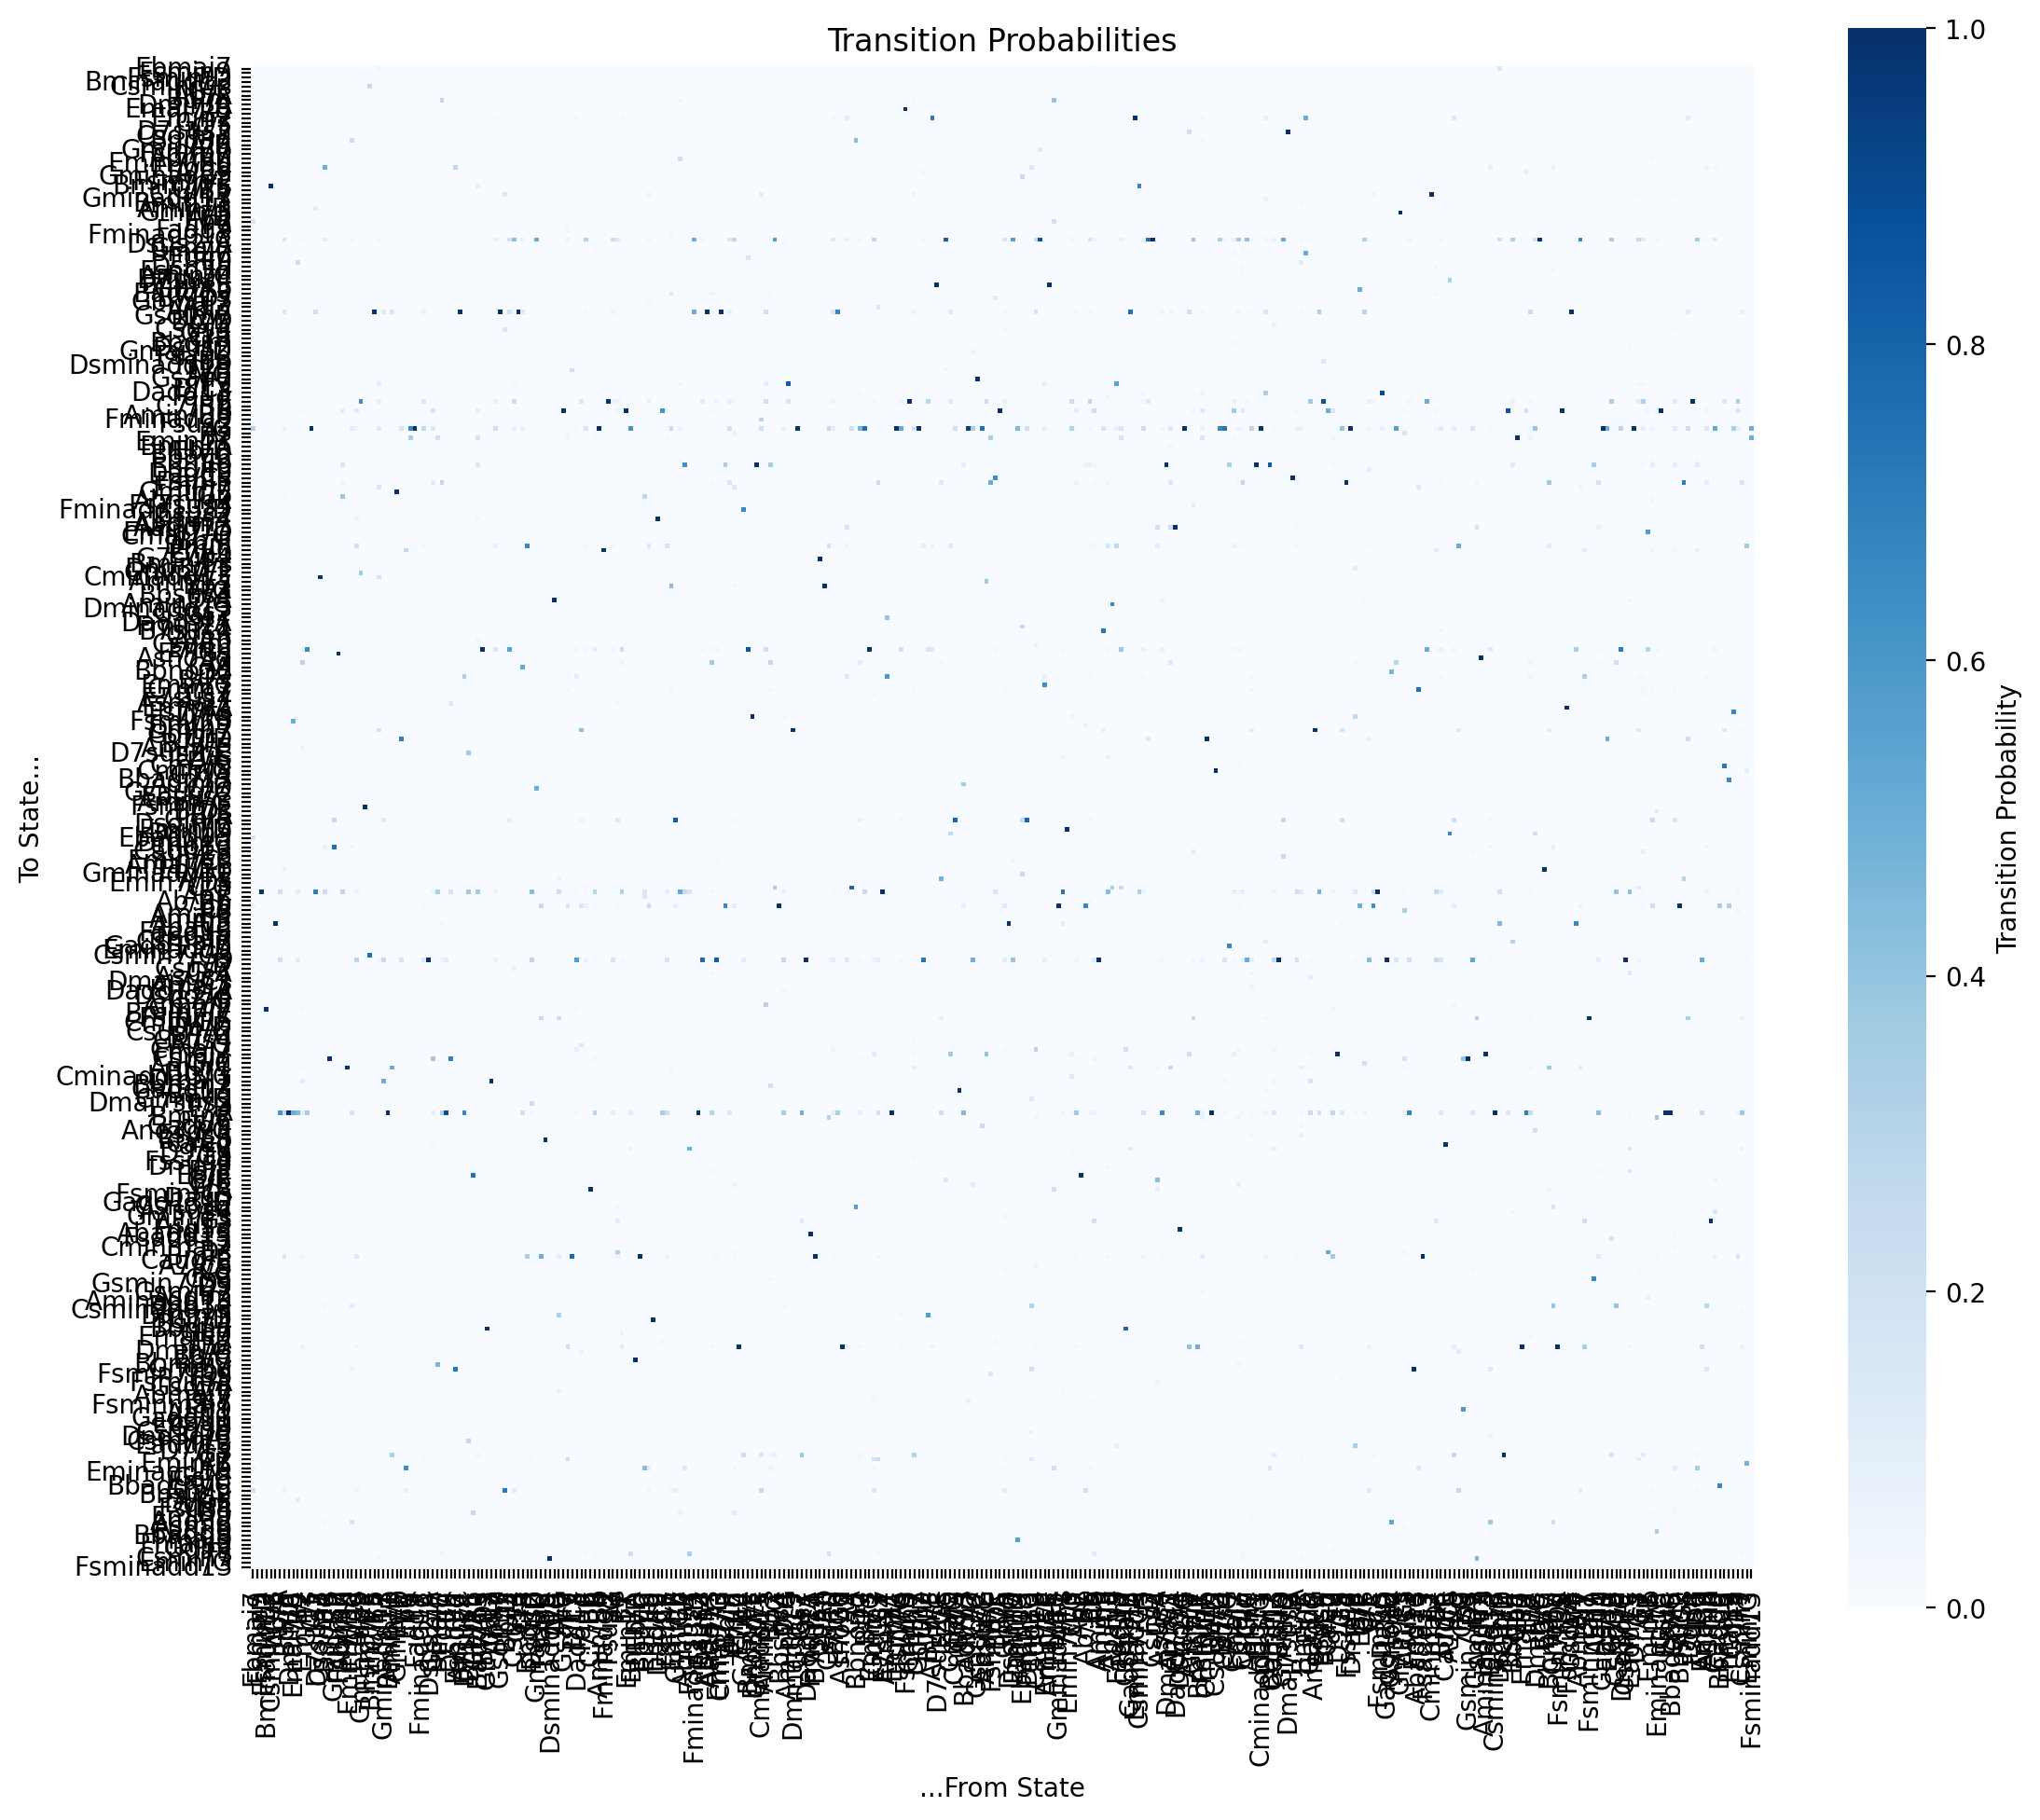

,Ebmaj7,Fsmin9,Fsmin/D,Bminadd13,Csmin/Gs,G/E,Ab/A,Bdim,Dmin/A,Emaj7/B,...,Asmin,Cadd9,Bbadd9,Fmaj9,Fmajs9,Gdim,Fs,Csmin7,Emin/G,Fsminadd13
Ebmaj7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
Fsmin9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
Fsmin/D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
Bminadd13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
Csmin/Gs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gdim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.012,0.000,0.0,0.0
Fs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.043,0.0,0.0
Csmin7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
Emin/G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0


In [ ]:
songs = get_songs(rock)
states = get_states(songs)
TM, tr_pr = transition_matrix_and_heat_map(states, songs)
TM

In [ ]:
new_chorale = generate_chords(states, 20, tr_pr, initial_state='G')
play_music(new_chorale)

Initial state: G


## Higher Order Markov Chains by Artist

In [ ]:
mayer = df.query("spotify_artist_id == '0hEurMDQu99nJRq8pTxO14'")
mayer.head()

,id,chords,release_date,genres,decade,rock_genre,artist_id,main_genre,spotify_song_id,spotify_artist_id
10647,10648,<verse_1> E13 Asus2 Bsus2 Fsmin9 E13 Asus2 Bsu...,2003-01-30,'neo mellow' 'singer-songwriter',2000.0,NaN,artist_6005,NaN,3ndvuL1lqZNTdb7yBxKQFR,0hEurMDQu99nJRq8pTxO14
64910,64911,<verse_1> Amin7 F7 G7 Amin7 <verse_2> F7 G7 Am...,2008,'neo mellow' 'singer-songwriter',2000.0,NaN,artist_6005,NaN,5e7ati4Dx5ax2YapfnV5FS,0hEurMDQu99nJRq8pTxO14
93075,93076,<intro_1> Bmin A G D <verse_1> G D G D A D G D...,2021-07-16,'neo mellow' 'singer-songwriter',2020.0,NaN,artist_6005,NaN,4f0xBbWvKWmuB17yebh24a,0hEurMDQu99nJRq8pTxO14
93734,93735,<intro_1> Dmin A/Cs Amin/C E Esus4 E <verse_1>...,2021-07-16,'neo mellow' 'singer-songwriter',2020.0,NaN,artist_6005,NaN,3hwjxbqGvTRUPi38fLgeM7,0hEurMDQu99nJRq8pTxO14
106766,106767,<verse_1> E Gsmin Csmin A E <verse_2> Gsmin Cs...,NaN,'neo mellow' 'singer-songwriter',NaN,NaN,artist_6005,NaN,NaN,0hEurMDQu99nJRq8pTxO14


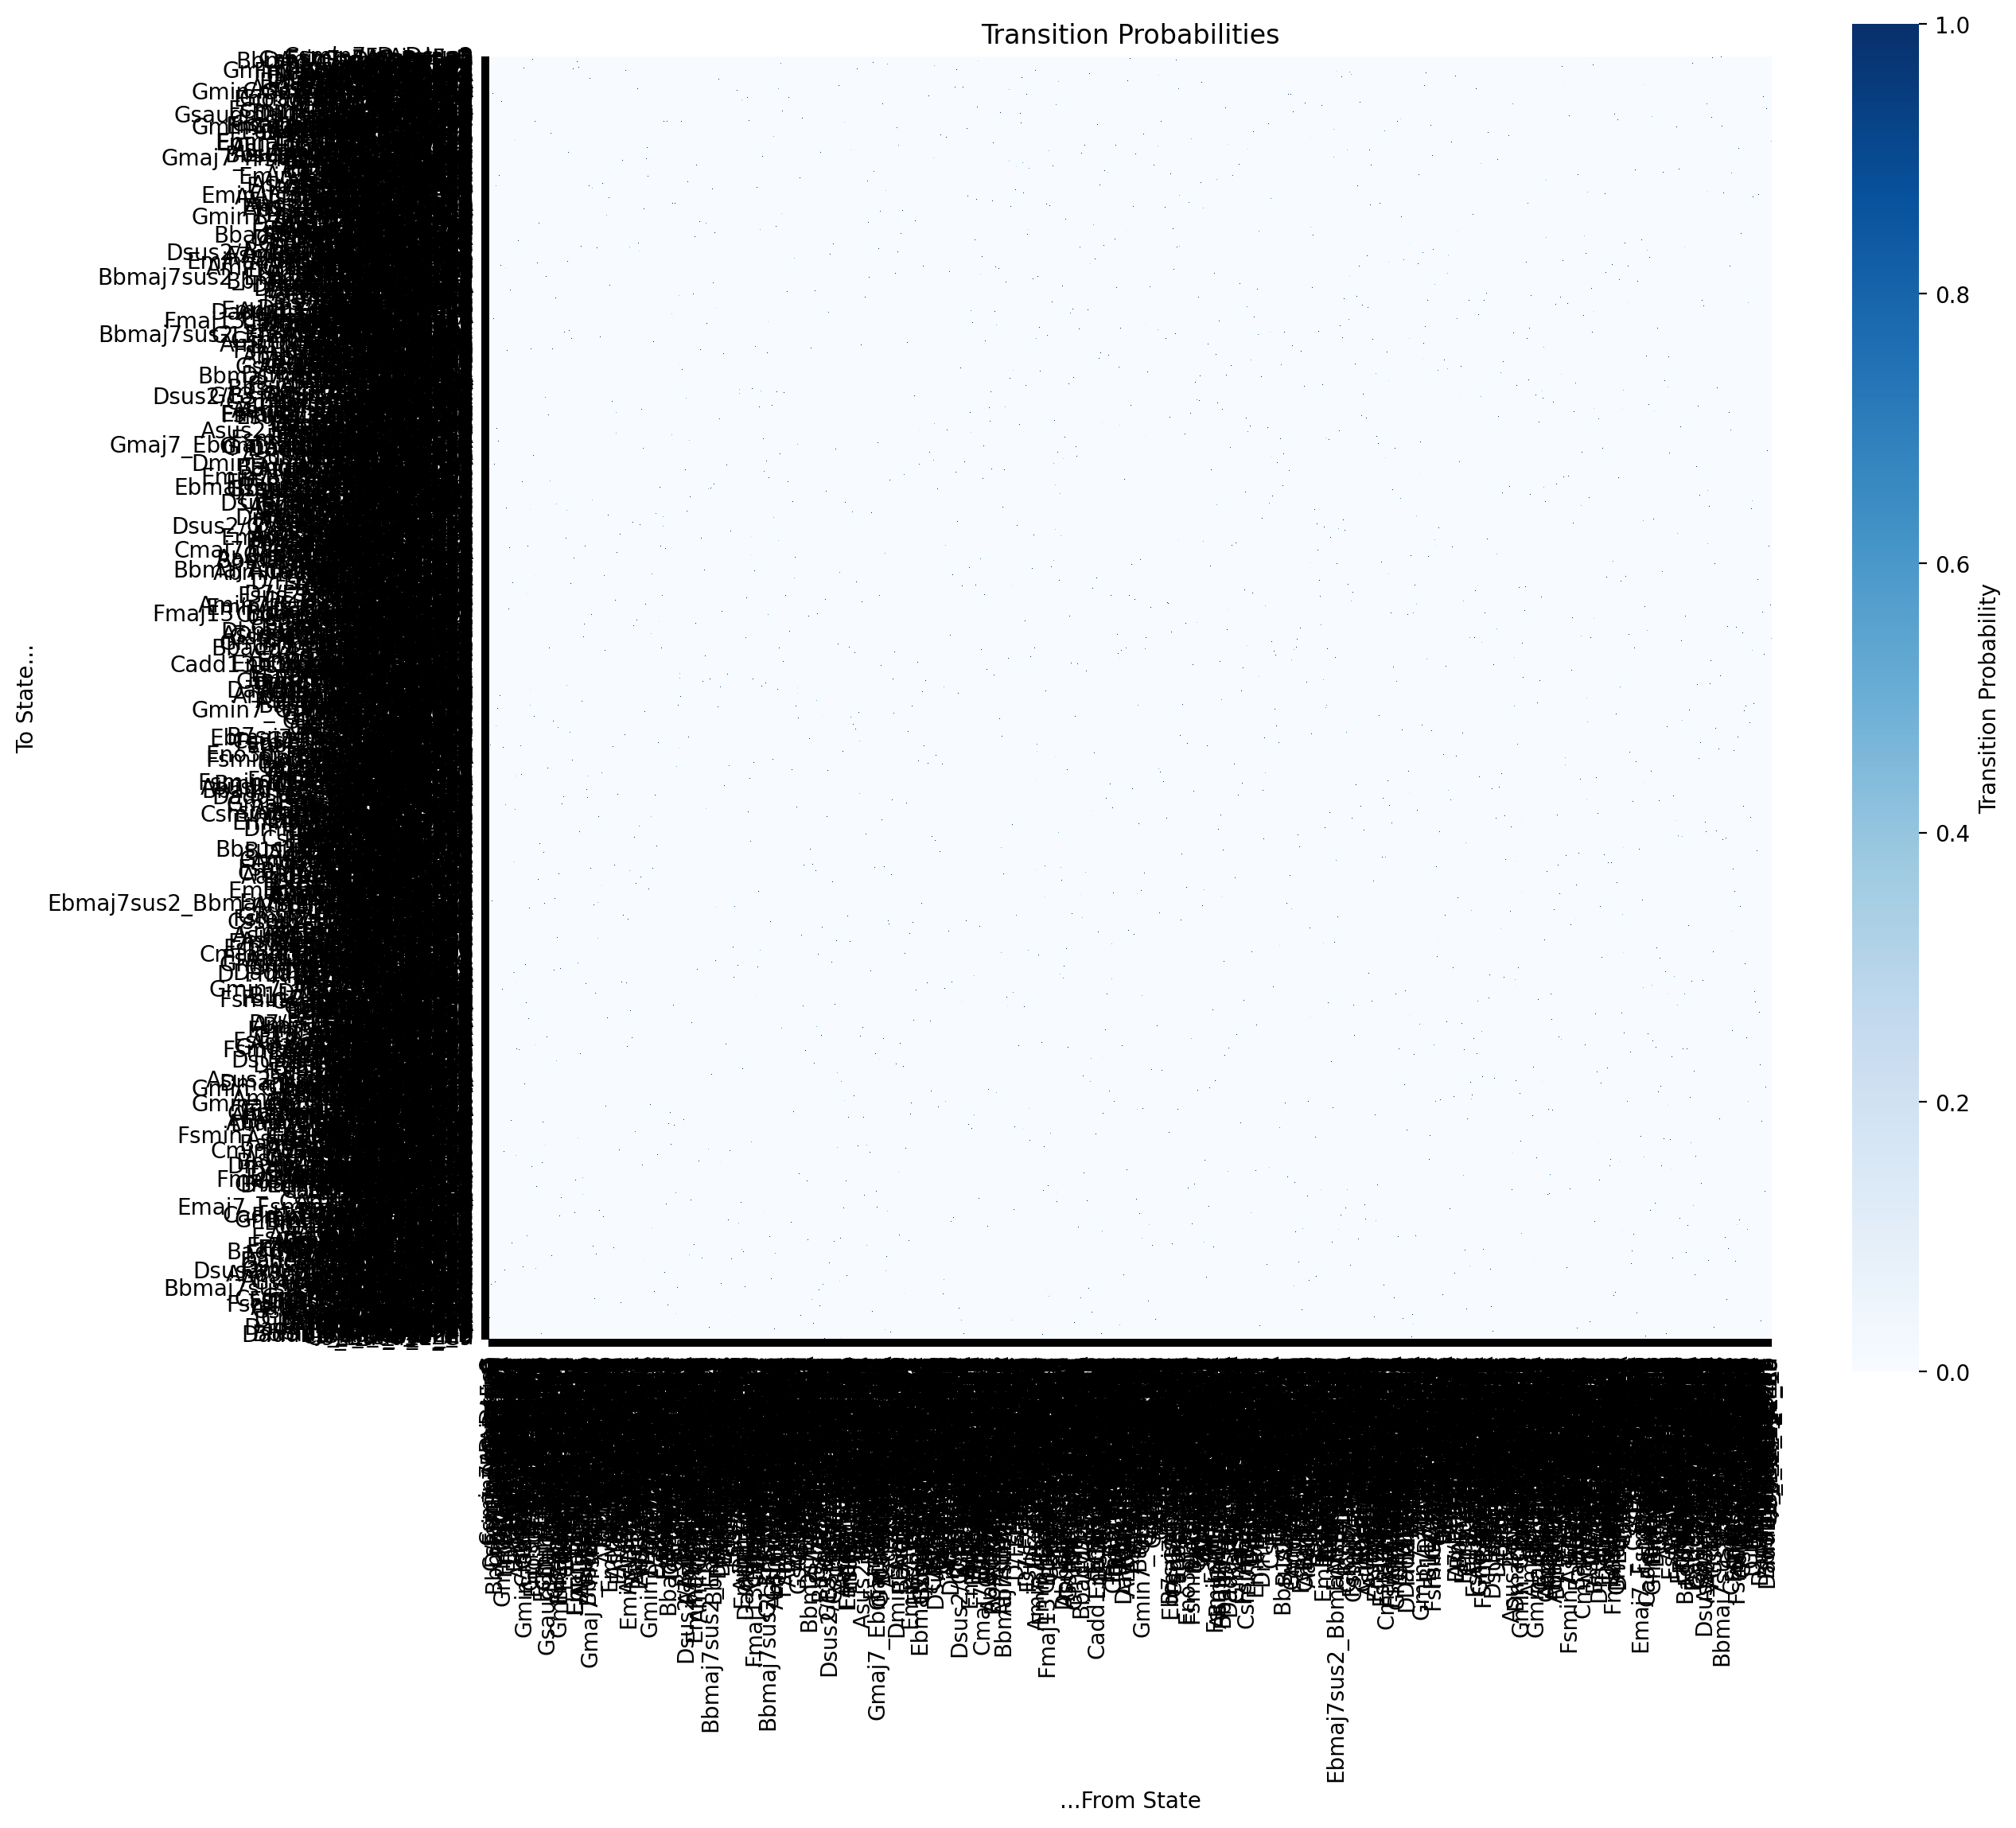

,Csmin7_D_Dsus2,F_Amin_G,Amin_F_G,Fsmin7_Csmin_D,Csmin7_D/A_Bmin7,A_Csmin_D,D/Fs_Gsus2_Dno3d,Bbmaj7_Dmin_Gmin7,G7_F7_Bb,A_E_G,...,G7_Cadd9_B7,Fsmin_Dmin_Emin,Fsmin7_B_Fsmin7,Bbmaj7_Amin_Dmin,Dadd11_Gsus2_Emin,As_Gsus2_B,Bb_Cmin7_Eb,Csmin7_Fs7_A9,C_F_Emin,C9_Dadd11_C9
Csmin7_D_Dsus2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F_Amin_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amin_F_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fsmin7_Csmin_D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Csmin7_D/A_Bmin7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As_Gsus2_B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bb_Cmin7_Eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Csmin7_Fs7_A9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C_F_Emin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
songs = get_songs(mayer)
mayer_states, mayer_songs = get_states(songs, order=3)
TM, tr_pr = transition_matrix_and_heat_map(mayer_states, mayer_songs)
TM

In [ ]:
strong_components = connected_components(tr_pr)
component_states = components_to_states(mayer_states, strong_components, 30)
component_states

Connected: False
Number of strongly connected components: 127


['E9_F7_A',
 'E9_F#7_A9',
 'A9_C#m7_F#7',
 'F7_A_F7',
 'A9_E9_Am',
 'C#m7_Em9_E9',
 'A_F7_A',
 'F7_A_Am',
 'A9_E9_F#7',
 'A_Am_G',
 'Am_D7_E9',
 'E9_F#7_A',
 'Em9_E9_A9',
 'A_Am_D7',
 'F#7_A9_E9',
 'A9_C#m7_Em9',
 'D7_E9_Am',
 'E9_A9_C#m7',
 'Am_G_A9',
 'E9_Am_D7',
 'D7_E9_F7',
 'D7_E9_A9',
 'F#7_A_Am',
 'C#m7_F#7_A9',
 'G_A9_E9']

In [ ]:
new_chorale = generate_chords(mayer_states, 20, tr_pr, initial_state='Am_G_A9')
new_chorale = flatten_chorale(new_chorale, 3)
print(new_chorale)
play_music(new_chorale)


Initial state: Am_G_A9
['Am', 'G', 'A9', 'E9', 'F#7', 'A9', 'E9', 'F#7', 'A9', 'E9', 'F#7', 'A9', 'E9', 'Am', 'D7', 'E9', 'Am', 'D7', 'E9', 'Am', 'D7', 'E9']
